# Topic Modelling using Amazon reviews (Automotive Products)



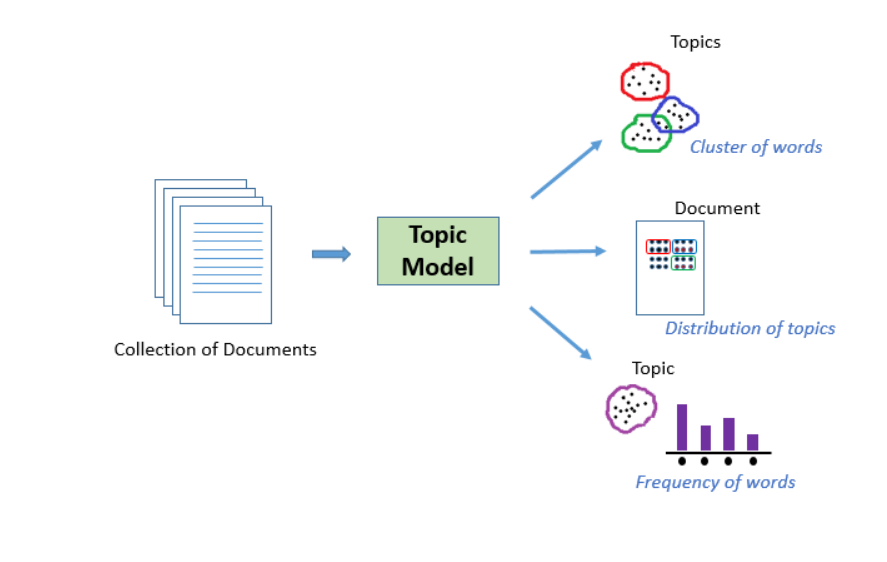

### What is topic modelling?
One of the major applications in Natural Language Processing is to extract what are the topics that are being discussed from large volumes of text. Some examples of large text are feeds from social media, customer reviews, feedbacks, news stories etc. Thus, an algorithm that can read through text documents and automatically output the topics discussed is Latent Dirichlet Allocation (LDA). 
I will be using the Latent Dirichlet Allocation (LDA) from Gensim package. 

LDA’s approach to topic modeling is it considers each document as a collection of topics in a certain proportion. And each topic as a collection of keywords, again, in a certain proportion.

Once you provide the algorithm with the number of topics, all it does it to rearrange the topics distribution within the documents and keywords distribution within the topics to obtain a good composition of topic-keywords distribution.

##### What is a topic?
A topic is nothing but a collection of dominant keywords that are typical representatives. Just by looking at the keywords, you can identify what the topic is all about.

We will also extract the volume and percentage contribution of each topic to get an idea of how important a topic is using a visualization in pyLDAvis.

In [1]:
#import packages

import nltk;
nltk.download('stopwords')

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[nltk_data] Downloading package stopwords to C:\Users\Kalpita
[nltk_data]     Raut\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\decomposition\nmf.py:972: DeprecationWarning: invalid escape sequence \s
  """
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\decomposition\nmf.py:1186: DeprecationWarning: invalid escape sequence \s
  """
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\manifold\t_sne.py:420: DeprecationWarning: invalid escape sequence \s
  """


## Reading and loading the Data

In [2]:
#read data
df = pd.read_json('Automotive_5.json', lines=True)
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B00002243X,"[4, 4]",5,I needed a set of jumper cables for my new car...,"08 17, 2011",A3F73SC1LY51OO,Alan Montgomery,Work Well - Should Have Bought Longer Ones,1313539200
1,B00002243X,"[1, 1]",4,"These long cables work fine for my truck, but ...","09 4, 2011",A20S66SKYXULG2,alphonse,Okay long cables,1315094400
2,B00002243X,"[0, 0]",5,Can't comment much on these since they have no...,"07 25, 2013",A2I8LFSN2IS5EO,Chris,Looks and feels heavy Duty,1374710400
3,B00002243X,"[19, 19]",5,I absolutley love Amazon!!! For the price of ...,"12 21, 2010",A3GT2EWQSO45ZG,DeusEx,Excellent choice for Jumper Cables!!!,1292889600
4,B00002243X,"[0, 0]",5,I purchased the 12' feet long cable set and th...,"07 4, 2012",A3ESWJPAVRPWB4,E. Hernandez,"Excellent, High Quality Starter Cables",1341360000


As you can see, the data contains the following columns:
- asin – ID of the product
- helpful – helpfulness rating of the review, e.g. 2/3
- overall – rating of the product
- reviewText – text of the review
- reviewTime – time of the review (raw)
- reviewerID – ID of the reviewer
- reviewerName – name of the reviewer
- summary – summary of the review
- unixReviewTime – time of the review (unix time)

For the scope of our analysis and this article, we will be using only the reviews column, i.e., **reviewText**.

## Steps for Preparing Data in Topic Modelling using LDA:


### 1. Tokenizing
Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.

In [3]:
# remove unwanted characters, numbers and symbols
df['reviewText'] = df['reviewText'].str.replace("[^a-zA-Z#]", " ")

### 2. Stopwords
Certain parts of English speech, like conjunctions (“for”, “or”) or the word “the” are meaningless to a topic model. These terms are called stop words and need to be removed from our token list.


In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [5]:
# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['reviewText']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

### 3. Lemmatizing
Lemmatization is nothing but converting a word to its root word. For example: the lemma of the word ‘machines’ is ‘machine’. Likewise, ‘walking’ –> ‘walk’, ‘mice’ –> ‘mouse’ and so on.

In [6]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

#### Let’s tokenize the reviews and then lemmatize the tokenized reviews

In [7]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['these', 'long', 'cables', 'work', 'fine', 'truck', 'quality', 'seems', 'little', 'shabby', 'side', 'for', 'money', 'expecting', 'dollar', 'snap', 'jumper', 'cables', 'seem', 'like', 'would', 'see', 'chinese', 'knock', 'shop', 'like', 'harbor', 'freight', 'bucks']


In [8]:
 # print lemmatized review
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1])

['long', 'cable', 'fine', 'truck', 'quality', 'little', 'shabby', 'side', 'money', 'dollar', 'jumper', 'cable', 'chinese', 'shop', 'harbor', 'freight', 'buck']


#### As you can see, we have not just lemmatized the words but also filtered only nouns and adjectives. Let’s de-tokenize the lemmatized reviews 

In [10]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

df['reviews'] = reviews_3



# Building a LDA model

First step in topic modelling is to convert your text into numeric representation using a document-term frequency matrix : **corpus**.

This matrix contains the word count for each word in each document and these words are called **vocabulary**.

Once we apply singlular value decomposition to the input(corpus) we will obtain 2 output matrices:
-	Document specific topic allocation
-	Topic specific word allocation 

In LDA, we apply statistical inference to obtain similar output but in the form of probability distribution 
-	Given a document, what is the probability distribution of each topic within the document
-	Given a specific topic, what is the word distribution from the vocabulary




In [11]:
#creating the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(reviews_2)


In [12]:
#converting the list of reviews (reviews_2) into a Document Term Matrix using the dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [19]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50)

**I have specified the number of topics as 10 for this model using the num_topics parameter.**

In [22]:
# Print the Keyword in the 10 topics
lda_model.print_topics()

[(0,
  '0.026*"good" + 0.021*"car" + 0.019*"oil" + 0.018*"product" + 0.015*"price" + 0.014*"filter" + 0.012*"time" + 0.011*"great" + 0.010*"quality" + 0.009*"year"'),
 (1,
  '0.093*"tire" + 0.076*"leather" + 0.053*"wheel" + 0.033*"gauge" + 0.029*"brush" + 0.024*"pressure" + 0.023*"seat" + 0.016*"air" + 0.016*"clean" + 0.014*"conditioner"'),
 (2,
  '0.034*"port" + 0.033*"brake" + 0.025*"board" + 0.025*"grease" + 0.019*"compressor" + 0.018*"seal" + 0.014*"film" + 0.014*"micro" + 0.012*"elbow" + 0.011*"project"'),
 (3,
  '0.067*"blade" + 0.056*"wiper" + 0.024*"windshield" + 0.018*"rain" + 0.015*"snow" + 0.013*"window" + 0.013*"bosch" + 0.013*"car" + 0.011*"old" + 0.011*"year"'),
 (4,
  '0.019*"easy" + 0.018*"good" + 0.015*"great" + 0.012*"use" + 0.011*"small" + 0.011*"work" + 0.011*"little" + 0.010*"nice" + 0.010*"thing" + 0.009*"fit"'),
 (5,
  '0.089*"light" + 0.038*"bulb" + 0.026*"bright" + 0.017*"white" + 0.014*"headlight" + 0.014*"color" + 0.013*"mat" + 0.012*"kit" + 0.009*"blue" + 0.

# INTERPRETATION:

Topic 0 is a represented as '0.026*"good" + 0.021*"car" + 0.019*"oil" + 0.018*"product" + 0.015*"price" + 0.014*"filter" + 0.012*"time" + 0.011*"great" + 0.010*"quality" + 0.009*"year"'),

It means the top 10 keywords that contribute to this topic are: ‘good’, ‘car’, ‘oil’.. and so on and the weight of ‘good’ on topic 0 is 0.026.

The weights reflect how important a keyword is to that topic.


- **Topic 1:** 
good,car,oil,product,price,filter,time,great,quality.year

- **Topic 2:**
tire,leather,wheel,gauge,brush,pressure,seat,air,clean,conditioner

- **Topic 3:**
port,brake,board,grease,compressor,seal,film,micro,elbow,project

- **Topic 4:**
blade,wiper,windshield,rain,snow,window,bosch,car,old,year

- **Topic 5:**
good,easy,great,use,small,work,little,nice,thing,fit

- **Topic 6:**
light,bulb,bright,white,headlight,color,mat,kit,blue,good

- **Topic 7:**
battery,car,power,device,unit,charger,light,use,phone,charger

- **Topic 8:**
car,product,towel,good,wax,clea,use,great,time,water

- **Topic 9:**
code,app,plug,tool,engine,reapir,sensor,,cap,scanner,computer

- **Topic 10:**
hose,water,tank,valve,pump,pressure,nozzle,sewer,black,air

# Visualization
To visualize our topics in a 2-dimensional space we will use the pyLDAvis library. This visualization is interactive in nature and displays topics along with the most relevant words.

In [21]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.187418  0.034961       1        1  21.606184
4     -0.168848 -0.030889       2        1  19.564924
0     -0.171309 -0.023421       3        1  18.620489
6     -0.139283 -0.033420       4        1  11.444353
5     -0.090189 -0.015624       5        1   7.788805
3     -0.101668 -0.024981       6        1   6.756716
9      0.142572  0.068460       7        1   4.554927
1      0.125408  0.226363       8        1   4.268203
2      0.316822  0.134047       9        1   2.851024
8      0.273912 -0.335497      10        1   2.544369, topic_info=     Category         Freq        Term        Total  loglift  logprob
term                                                                 
148   Default  4519.000000       light  4519.000000  30.0000  30.0000
337   Default  2177.000000        tire  2177.000000  29.0000  29.0000
39    Default  3171.000000     battery  3171.000000  28.0000  28.0000
955   Default  2466.000000       blade  2466.000000  27.0000  27.0000
525   Default  2782.000000       water  2782.000000  26.0000  26.0000
2     Default  9886.000000         car  9886.000000  25.0000  25.0000
1319  Default  1767.000000     leather  1767.000000  24.0000  24.0000
931   Default  2055.000000       wiper  2055.000000  23.0000  23.0000
728   Default  1463.000000        hose  1463.000000  22.0000  22.0000
530   Default  2865.000000       towel  2865.000000  21.0000  21.0000
2586  Default  1605.000000        bulb  1605.000000  20.0000  20.0000
722   Default  1225.000000       wheel  1225.000000  19.0000  19.0000
754   Default  1216.000000        tool  1216.000000  18.0000  18.0000
62    Default  1636.000000       power  1636.000000  17.0000  17.0000
118   Default  1167.000000      engine  1167.000000  16.0000  16.0000
169   Default  1904.000000         oil  1904.000000  15.0000  15.0000
320   Default  6699.000000     product  6699.000000  14.0000  14.0000
791   Default   969.000000        plug   969.000000  13.0000  13.0000
95    Default  2466.000000       clean  2466.000000  12.0000  12.0000
526   Default  1891.000000         wax  1891.000000  11.0000  11.0000
1275  Default  1088.000000      bright  1088.000000  10.0000  10.0000
726   Default   725.000000        code   725.000000   9.0000   9.0000
760   Default  1223.000000      device  1223.000000   8.0000   8.0000
51    Default   765.000000       gauge   765.000000   7.0000   7.0000
930   Default   885.000000  windshield   885.000000   6.0000   6.0000
733   Default  1232.000000        unit  1232.000000   5.0000   5.0000
966   Default  1405.000000      filter  1405.000000   4.0000   4.0000
6897  Default   636.000000         app   636.000000   3.0000   3.0000
235   Default   879.000000        seat   879.000000   2.0000   2.0000
1103  Default   964.000000    pressure   964.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
780   Topic10   160.372223       error   161.140747   3.6665  -4.4618
761   Topic10   129.093124  diagnostic   129.861572   3.6654  -4.6787
2287  Topic10   126.977707      gasket   127.746185   3.6653  -4.6953
61    Topic10   125.739861         pop   126.508469   3.6652  -4.7051
6960  Topic10   125.347160       crash   126.116158   3.6652  -4.7082
5824  Topic10   122.654449      reader   123.422897   3.6650  -4.7299
795   Topic10   115.804970       spark   116.573387   3.6647  -4.7874
755   Topic10   111.359169       track   112.127823   3.6644  -4.8265
1843  Topic10   106.670486     trigger   107.439384   3.6641  -4.8695
1187  Topic10    90.325653         web    91.094208   3.6628  -5.0359
2153  Topic10    76.576736        info    77.345383   3.6613  -5.2010
8879  Topic10    75.648743         vin    76.417206   3.6612  -5.2132
8873  Topic10    75.099487      innova    75.867943   3.6611  -5.2205
4383  Topic10    68.751869     primary    69.520653   3.6602  -5.3088
5595  Topic10    65

## Interpreting the Visualization

- Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.
- The size of the bubbles represent the percentage of topics in the corpus. For example, Topic 7 contains 4.6% of tokens in the corpus. 
- A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant. As we observe, out of the 10 topics,topic 1-6 overlap whereas topic 7-10 do not. Thus, we have built a good topic model.



## Results & Discussion

Looking at the topics, we can summarize that they represent information about cars and car parts.

The following can be the topic summary for each topic:
- **Topic 1: (Regarding car Quality)** 
good,car,oil,product,price,filter,time,great,quality,year

- **Topic 2:(Regarding Parts of the car)**
tire,leather,wheel,gauge,brush,pressure,seat,air,clean,conditioner

- **Topic 3:(Regarding car tools)**
port,brake,board,grease,compressor,seal,film,micro,elbow,project

- **Topic 4:(Regarding Parts of the car)**
blade,wiper,windshield,rain,snow,window,bosch,car,old,year

- **Topic 5:(Quality review)**
good,easy,great,use,small,work,little,nice,thing,fit

- **Topic 6:(Regarding colour and appeal)**
light,bulb,bright,white,headlight,color,mat,kit,blue,good

- **Topic 7:(Regarding car power supply)**
battery,car,power,device,unit,charger,light,use,phone,charger

- **Topic 8:(Regarding car maintainance)**
car,product,towel,good,wax,clea,use,great,time,water

- **Topic 9:(Regarding electronic car applications)**
code,app,plug,tool,engine,reapir,sensor,cap,scanner,computer

- **Topic 10:(Regarding fuel and internal parts of engine)**
hose,water,tank,valve,pump,pressure,nozzle,sewer,black,air


Thus, I agree with the topics that I have found. Most of the keywords in each topic are relevant to what the topic is about.  
 

 

## Do online communities always stay on topic?

Out of the thousands of reviews in our dataset, some keywords that are outside of the focus of the topic were observed. We observe using the visualization & the top 10 words mentioned above, that some keywords don't match what the topic represents. Some of these are: 
 - Topic 3: elbow,port
 - Topic 4: year
 - Topic 6: mat
 - Topic 8: towel, time, water, shoe
 - Topic 10: hose, sewer, air
 
However, these anamolies are quite negligible as compared to the other keyowrds that perfectly relate to what the topic represents. With respect to the observations in this study, we can conclude that most of the topics were relevant to what that particular topic represented. Thus, online communities mostly tend to stay on topic. 

## Citations:
1. For the visualization :  https://pyldavis.readthedocs.io/en/latest/readme.html#usage
2. For dataset: R. He, J. McAuley. Modeling the visual evolution of fashion trends with one-class collaborative filtering. WWW, 2016 J. McAuley, C. Targett, J. Shi, A. van den Hengel. Image-based recommendations on styles and substitutes. SIGIR, 2015
